Import required libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from ISLP import load_data

Load Carseats dataset

In [2]:
data = load_data('Carseats')

# Convert categorical variables to numerical
data['Y']= (data['Sales']>=8).astype(int)
data['ShelveLoc_enc']= LabelEncoder().fit_transform(data['ShelveLoc'])
data['Urban_enc']= LabelEncoder().fit_transform(data['Urban'])
data['US_enc']= LabelEncoder().fit_transform(data['US'])

Checking the data about and prerpross if required

In [3]:
print("The dimension of the data is",data.shape)
display(data.head())
display(data.dtypes)

The dimension of the data is (400, 15)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Y,ShelveLoc_enc,Urban_enc,US_enc
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1,0,1,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1,1,1,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1,2,1,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0,2,1,1
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0,0,1,0


Sales             float64
CompPrice           int64
Income              int64
Advertising         int64
Population          int64
Price               int64
ShelveLoc        category
Age                 int64
Education           int64
Urban            category
US               category
Y                   int64
ShelveLoc_enc       int64
Urban_enc           int64
US_enc              int64
dtype: object

Define X and y with a split of random 300 samples in train and rest in test sets

In [4]:
train_data = data.sample(n=300, random_state=0)
test_data = data.drop(train_data.index)

X_train = train_data.drop(columns=['Sales', 'Y', 'ShelveLoc', 'Urban', 'US'])
y_train = train_data['Y']
X_test = test_data.drop(columns=['Sales', 'Y', 'ShelveLoc', 'Urban', 'US'])
y_test = test_data['Y']

### Fully Grown Tree

In [5]:
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train, y_train)

print("Train Accuracy:", dtree.score(X_train, y_train))
print("Test Accuracy:", dtree.score(X_test, y_test))

print('\nTree depth:', dtree.tree_.max_depth)
print('Tree node count:', dtree.tree_.node_count)

Train Accuracy: 1.0
Test Accuracy: 0.75

Tree depth: 10
Tree node count: 97


Plot tree (Optional)

[Text(0.4292763157894737, 0.9545454545454546, 'Advertising <= 6.5\ngini = 0.487\nsamples = 300\nvalue = [174, 126]'), Text(0.19407894736842105, 0.8636363636363636, 'Price <= 90.5\ngini = 0.405\nsamples = 163\nvalue = [117, 46]'), Text(0.31167763157894735, 0.9090909090909092, 'True  '), Text(0.05263157894736842, 0.7727272727272727, 'CompPrice <= 109.0\ngini = 0.375\nsamples = 24\nvalue = [6, 18]'), Text(0.03508771929824561, 0.6818181818181818, 'Income <= 75.0\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'), Text(0.017543859649122806, 0.5909090909090909, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'), Text(0.05263157894736842, 0.5909090909090909, 'Price <= 79.5\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'), Text(0.03508771929824561, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'), Text(0.07017543859649122, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'), Text(0.07017543859649122, 0.6818181818181818, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'), Text(0.3355263157894737, 0.7727272727272727, 'Comp

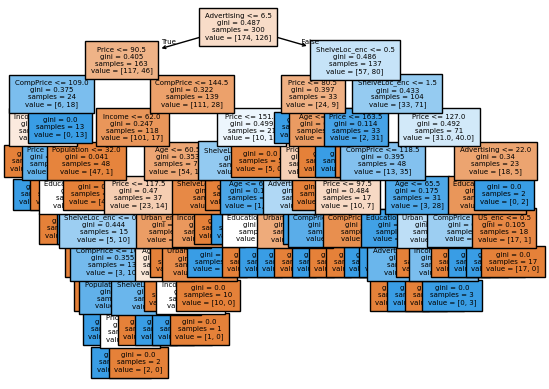

In [6]:
figsize = (20, 10)
print(plot_tree(dtree, filled=True, feature_names=X_train.columns, fontsize=5))

Cost complexity pruning

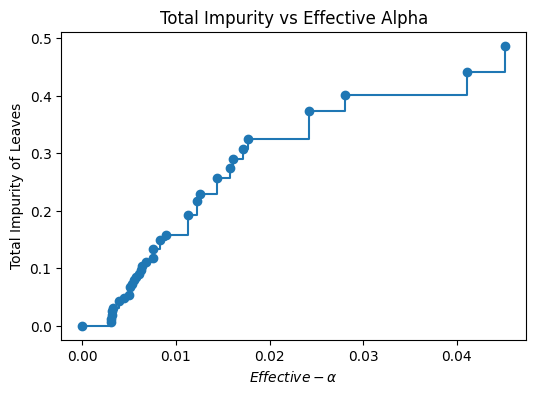

In [7]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.figure(figsize=(6, 4))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel(r'$Effective-\alpha$')
plt.ylabel('Total Impurity of Leaves')
plt.title('Total Impurity vs Effective Alpha')
plt.show()

Total number of unique alpha values:  31


Text(0.5, 0, 'Effective-$\\alpha$')

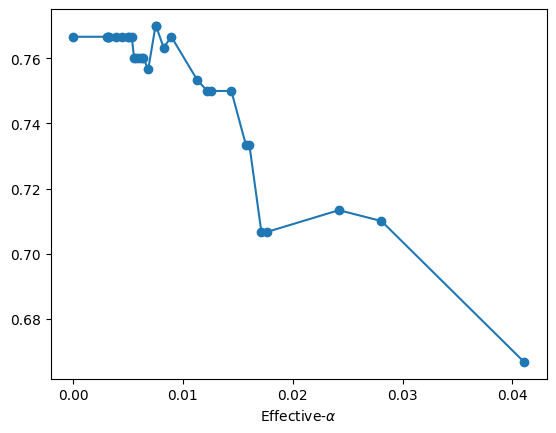

In [8]:
# Remove the last tree (only root), not useful for accuracy
ccp_alphas = np.unique(ccp_alphas)[:-1]
print("Total number of unique alpha values: ",len(ccp_alphas))

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

cv_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]
plt.plot(ccp_alphas, cv_scores, marker='o')
plt.xlabel(r'Effective-$\alpha$')

In [9]:
# Best alpha value
best_alpha = path.ccp_alphas[np.argmax(cv_scores)]
print("Best alpha value: ",best_alpha)

Best alpha value:  0.006837606837606834


### Pruned Tree

In [10]:
pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

print("Train Accuracy:", pruned_tree.score(X_train, y_train))
print("Test Accuracy:", pruned_tree.score(X_test, y_test))

print('\nTree depth:', pruned_tree.tree_.max_depth)
print('Tree node count:', pruned_tree.tree_.node_count)

Train Accuracy: 0.9333333333333333
Test Accuracy: 0.75

Tree depth: 8
Tree node count: 47


Nodes and Depth vs alpha

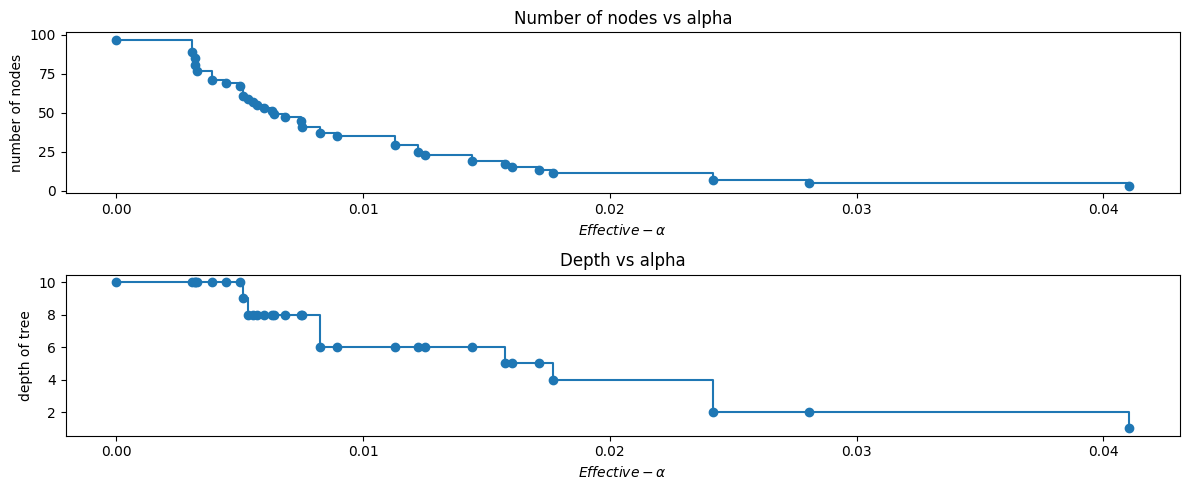

In [11]:
# clfs already calculated before, so we can directly plot it
node_counts = [clf.tree_.node_count for clf in clfs]
depths = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel(r'$Effective-\alpha$')
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depths, marker="o", drawstyle="steps-post")
ax[1].set_xlabel(r'$Effective-\alpha$')
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

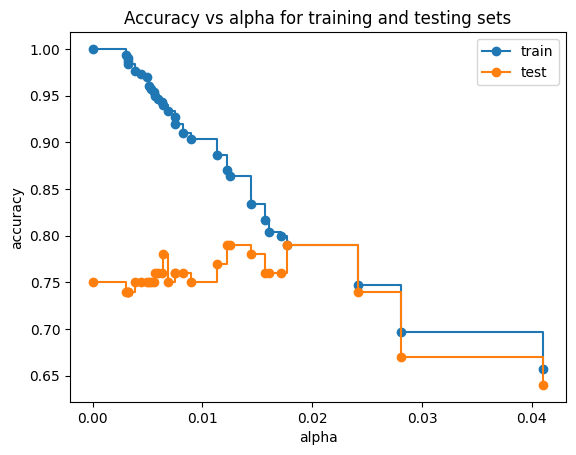

In [12]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
plt.legend()
plt.show()

Store as dataframe

In [13]:
cv_data = pd.DataFrame({
      'alpha': ccp_alphas,
      'cv_scores': cv_scores,
      'node_count': node_counts,
      'depth': depths,
      'train_score': train_scores,
      'test_score': test_scores
})
print(cv_data.head())
#pd.save_csv(cv_data, 'regtree_california_housing_cv_data.csv', index=False)

      alpha  cv_scores  node_count  depth  train_score  test_score
0  0.000000   0.766667          97     10     1.000000        0.75
1  0.003056   0.766667          89     10     0.993333        0.74
2  0.003205   0.766667          85     10     0.990000        0.74
3  0.003207   0.766667          81     10     0.986667        0.74
4  0.003264   0.766667          77     10     0.983333        0.74


# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(max_iter=50000)
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 0.82
Test Accuracy: 0.84
